In [112]:
library("dndscv")
library(dplyr)
library("biomaRt")
library(MASS) 
library(ggplot2)
library(lmtest)
library(stringr)
library(VennDiagram)
library(readr)

In [4]:
# data("dataset_simbreast", package="dndscv")
# dndsout = dndscv(mutations)

In [113]:
# head(dndsout$sel_cv)

In [114]:
# dndsout$globaldnds

In [115]:
# head(dndsout$annotmuts)

In [116]:
# print(dndsout$nbreg$theta)

# STAU mutation

In [117]:
STAD_mutation = read_tsv("/Users/shuhaoxu/Desktop/BNFO285/Groupproject/Project2/TCGA.STAD.mutations.txt", quote="\"")

Rows: 234941 Columns: 53
── Column specification ───────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (44): patient_id, Hugo_Symbol, Center, NCBI_Build, Chromosome, Strand, V...
dbl  (9): Entrez_Gene_Id, Start_Position, End_Position, t_depth, t_ref_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [118]:
nrow(STAD_mutation)

[1] 234941

# make oncoDriveFML input

In [119]:
oncoDriveFML <- STAD_mutation[STAD_mutation$VARIANT_CLASS == "SNV",]

In [120]:
colnames(oncoDriveFML)

[1] "patient_id"                  "Hugo_Symbol"                
 [3] "Entrez_Gene_Id"              "Center"                     
 [5] "NCBI_Build"                  "Chromosome"                 
 [7] "Start_Position"              "End_Position"               
 [9] "Strand"                      "Variant_Classification"     
[11] "Variant_Type"                "Reference_Allele"           
[13] "Tumor_Seq_Allele1"           "Tumor_Seq_Allele2"          
[15] "dbSNP_RS"                    "dbSNP_Val_Status"           
[17] "Tumor_Sample_Barcode"        "Matched_Norm_Sample_Barcode"
[19] "Match_Norm_Seq_Allele1"      "Tumor_Validation_Allele1"   
[21] "Tumor_Validation_Allele2"    "HGVSc"                      
[23] "HGVSp"                       "Transcript_ID"              
[25] "t_depth"                     "t_ref_count"                
[27] "t_alt_count"                 "n_depth"                    
[29] "Allele"                      "Consequence"                
[31] "cDNA_position"               "CDS_position"               
[33] "Protein_position"            "Amino_acids"                
[35] "Codons"                      "Existing_variation"         
[37] "STRAND"                      "CANONICAL"                  
[39] "CCDS"                        "ENSP"                       
[41] "SWISSPROT"                   "TREMBL"                     
[43] "UNIPARC"                     "SIFT"                       
[45] "PolyPhen"                    "DOMAINS"                    
[47] "IMPACT"                      "VARIANT_CLASS"              
[49] "FILTER"                      "COSMIC"                     
[51] "CALLERS"                     "CONTEXT"                    
[53] "NCALLERS"

In [121]:
oncoDrive_input = oncoDriveFML[, c("Chromosome", "Start_Position", "Reference_Allele", "Tumor_Seq_Allele2", "patient_id")]

In [122]:
colnames(oncoDrive_input) <- c("CHROMOSOME", "POSITION", "REF", "ALT", "SAMPLE")

In [9]:
# write.table(oncoDrive_input, file='oncoDriveFML.tsv', sep='\t', quote=FALSE, row.names=FALSE)

# Make CBASE Input

In [123]:
seqs <- c(
  "AAAAA", "AAAAC", "AAAAG", "AAAAT", "AAACA", "AAACC", "AAACG", "AAACT",
  "AAAGA", "AAAGC", "AAAGG", "AAAGT", "AAATA", "AAATC", "AAATG", "AAATT",
  "AACAA", "AACAC", "AACAG", "AACAT", "AACCA", "AACCC", "AACCG", "AACCT",
  "AACGA", "AACGC", "AACGG", "AACGT", "AACTA", "AACTC", "AACTG", "AACTT",
  "AAGAA", "AAGAC", "AAGAG", "AAGAT", "AAGCA", "AAGCC", "AAGCG", "AAGCT",
  "AAGGA", "AAGGC", "AAGGG", "AAGGT", "AAGTA", "AAGTC", "AAGTG", "AAGTT",
  "AATAA", "AATAC", "AATAG", "AATAT", "AATCA", "AATCC", "AATCG", "AATCT",
  "AATGA", "AATGC", "AATGG", "AATGT", "AATTA", "AATTC", "AATTG", "AATTT"
)

keys <- substr(seqs, 3, 5)
values <- 0:(length(seqs) - 1)
context_dict <- setNames(values, keys)

In [124]:
context_dict

AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ATT CAA CAC CAG CAT 
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
CCA CCC CCG CCT CGA CGC CGG CGT CTA CTC CTG CTT GAA GAC GAG GAT GCA GCC GCG GCT 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
GGA GGC GGG GGT GTA GTC GTG GTT TAA TAC TAG TAT TCA TCC TCG TCT TGA TGC TGG TGT 
 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59 
TTA TTC TTG TTT 
 60  61  62  63

In [125]:
cbase_input = STAD_mutation %>% filter(VARIANT_CLASS == "SNV")
cbase_input = cbase_input %>% dplyr::select(c(patient_id, Hugo_Symbol, Chromosome,
                                       Start_Position, Reference_Allele, Tumor_Seq_Allele2,
                                       Variant_Classification, CONTEXT))
cbase_input <- cbase_input %>%
  mutate(
    # context = substr(context_5, 2, 4),
    context = substr(CONTEXT, (nchar(CONTEXT) - 4) %/% 2 + 1, (nchar(CONTEXT) - 4) %/% 2 + 5),
    index = context_dict[context]
  )

cbase_input = cbase_input %>% filter(Variant_Classification != "3'Flank") %>% filter(Variant_Classification != "5'Flank")
cbase_input <- cbase_input %>%
  mutate(annotate = case_when(
    Variant_Classification == "Missense_Mutation" ~ "missense",
    Variant_Classification == "Nonsense_Mutation" ~ "nonsense",
    Variant_Classification == "Silent" ~ "coding-synon",
    Variant_Classification == "3'UTR" ~ "utr-3",
    Variant_Classification == "5'UTR" ~ "utr-5"
  ))

cbase_input = cbase_input %>% dplyr::select(c(Hugo_Symbol, annotate, Tumor_Seq_Allele2, context))
colnames(cbase_input) <- c("Gene", "mut_eff", "mut_nuc", "context")
# write.table(cbase_input, file='cbase_input.tsv', sep='\t', quote=FALSE, row.names=FALSE)

## Filter out patients with too many mutations

In [126]:
sample_mutation_counts <- table(STAD_mutation$patient_id)
print(length(sample_mutation_counts))
hypermutators_patient <- names((sample_mutation_counts[sample_mutation_counts > 3000]))
length(hypermutators_patient)

[1] 415


[1] 12

In [127]:
STAD_mutation_filtered_patient <- STAD_mutation %>% filter(!patient_id %in% hypermutators_patient)
nrow(STAD_mutation_filtered_patient)

[1] 169537

## Filter out genes with too many mutations

In [128]:
gene_mutation_counts <- table(STAD_mutation$Hugo_Symbol)
print(length(gene_mutation_counts))
hypermutators_gene <- names((gene_mutation_counts[gene_mutation_counts > 300]))
length(hypermutators_gene)

[1] 18933


[1] 2

In [129]:
STAD_mutation_filtered_patient_gene <- STAD_mutation_filtered_patient %>% filter(!Hugo_Symbol %in% hypermutators_gene)
nrow(STAD_mutation_filtered_patient_gene)

[1] 168541

## Filter for mutations that pass

In [152]:
STAD_mutation_filtered_pass <- STAD_mutation_filtered_patient_gene %>% filter(FILTER == "PASS")
nrow(STAD_mutation_filtered_pass)

[1] 155460

### keep only SNV

In [153]:
# STAD_mutation_filtered_pass <- STAD_mutation_filtered_pass[STAD_mutation_filtered_pass$Variant_Type == "SNP",]
STAD_mutation_filtered_pass <- STAD_mutation_filtered_pass[STAD_mutation_filtered_pass$VARIANT_CLASS == "SNV",]
nrow(STAD_mutation_filtered_pass)



[1] 135499

In [20]:
# STAD_mutation_filtered_pass <- STAD_mutation_filtered_pass[STAD_mutation_filtered_pass$Start_Position == STAD_mutation_filtered_pass$End_Position,]
# nrow(STAD_mutation_filtered_pass)



# calculate avg sift

In [154]:
STAD_mutation_filtered_pass <- STAD_mutation_filtered_pass %>%
mutate(
  SIFT_numeric = as.numeric(str_extract(SIFT, "(?<=\\()\\d*\\.?\\d*(?=\\))")),
  SIFT = ifelse(SIFT == ".", NA, SIFT)
)

## Annotate the mutations with gene name using the transcript id

In [22]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
transcript_ids <- unique(STAD_mutation_filtered_pass$Transcript_ID)

transcript_data <- getBM(attributes = c("ensembl_transcript_id", "hgnc_symbol", "transcript_length"),
                         filters = "ensembl_transcript_id",
                         values = transcript_ids,
                         mart = ensembl)

gene_lengths <- transcript_data %>%
  group_by(hgnc_symbol) %>%
  summarise(gene_length = max(transcript_length, na.rm = TRUE)) %>%
  ungroup()


# Aggregate mutations and annotate with gene lengths

In [155]:
mutation_counts <- STAD_mutation_filtered_pass %>% 
  group_by(Hugo_Symbol) %>% 
  summarise(observed_mutations = n()) %>% 
  ungroup()

mutation_counts_with_GeneLength <- mutation_counts %>%
  left_join(gene_lengths, by = c("Hugo_Symbol" = "hgnc_symbol"))

mutation_counts_filtered <- mutation_counts_with_GeneLength %>%
  filter(!is.na(gene_length))

mutation_counts_filtered$log_gene_length <- log(mutation_counts_filtered$gene_length + 1e-6)

# Determine the distribution of the data

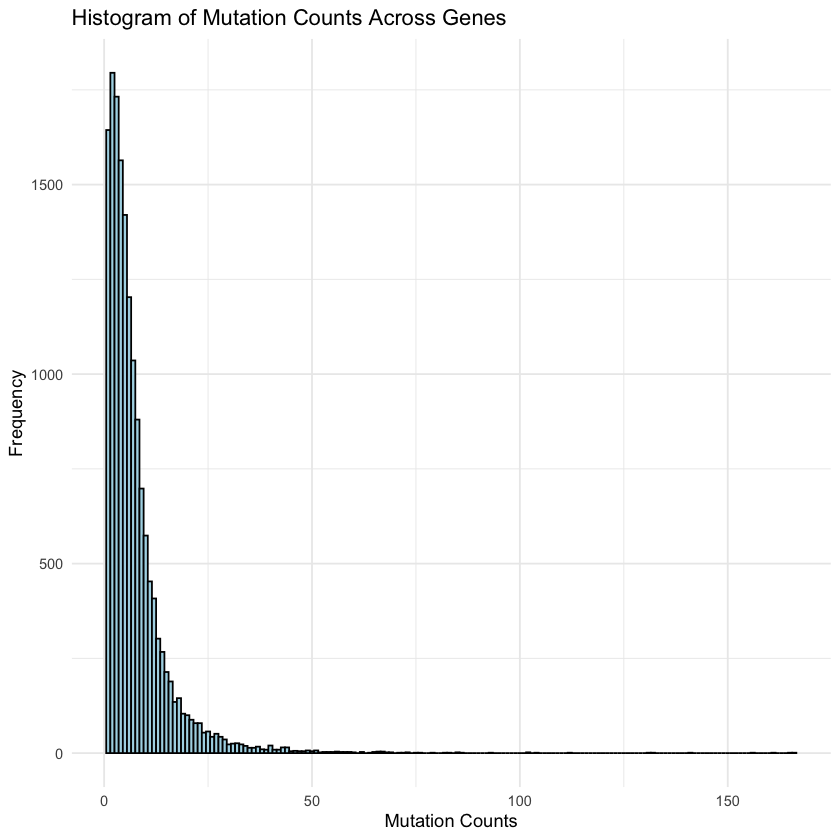

Dispersion (variance/mean): 9.360724 
Observed zeros: 0 
Expected zeros under Poisson: 8.298607 


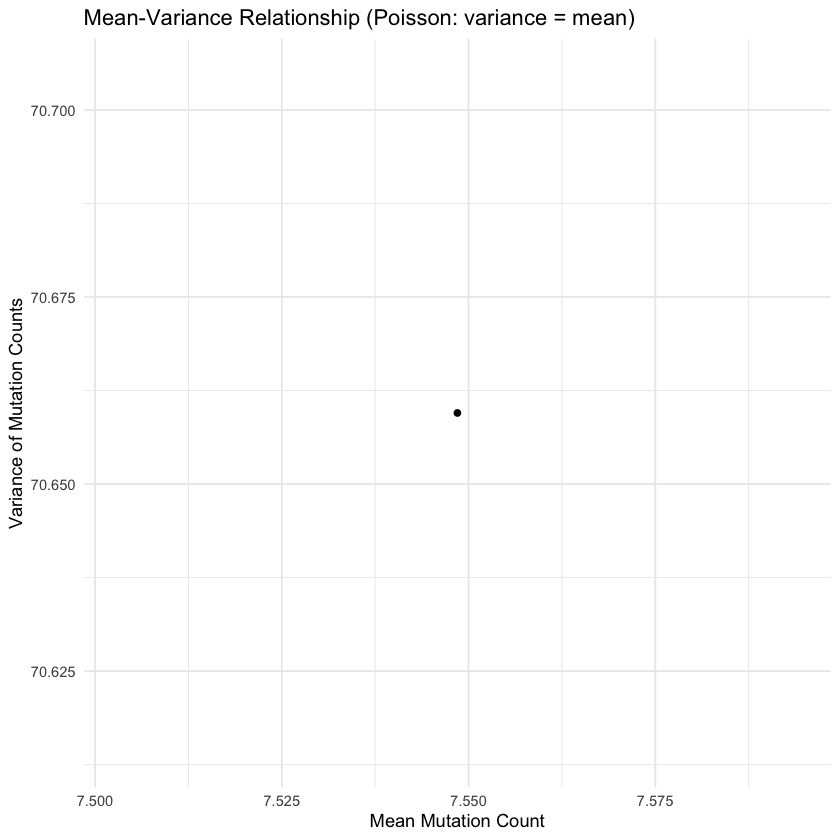

In [25]:
ggplot(mutation_counts_filtered, aes(x = observed_mutations)) +
  geom_histogram(binwidth = 1, fill = "lightblue", color = "black") +
  labs(x = "Mutation Counts", y = "Frequency", 
       title = "Histogram of Mutation Counts Across Genes") +
  theme_minimal()

mean_counts <- mean(mutation_counts_filtered$observed_mutations)
var_counts <- var(mutation_counts_filtered$observed_mutations)
plot_data <- data.frame(mean = mean_counts, variance = var_counts)

ggplot(plot_data, aes(x = mean, y = variance)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Mean Mutation Count", y = "Variance of Mutation Counts",
       title = "Mean-Variance Relationship (Poisson: variance = mean)") +
  theme_minimal()

dispersion <- var(mutation_counts_filtered$observed_mutations) / mean(mutation_counts_filtered$observed_mutations)
cat("Dispersion (variance/mean):", dispersion, "\n")

observed_zeros <- sum(mutation_counts_filtered$observed_mutations == 0)
expected_zeros_poisson <- sum(dpois(0, lambda = mean(mutation_counts_filtered$observed_mutations)) * nrow(mutation_counts_filtered))
cat("Observed zeros:", observed_zeros, "\n")
cat("Expected zeros under Poisson:", expected_zeros_poisson, "\n")

`geom_smooth()` using formula = 'y ~ x'



	Pearson's product-moment correlation

data:  mutation_counts_filtered$gene_length and mutation_counts_filtered$observed_mutations
t = 75.956, df = 15748, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5062825 0.5291443
sample estimates:
      cor 
0.5178058 



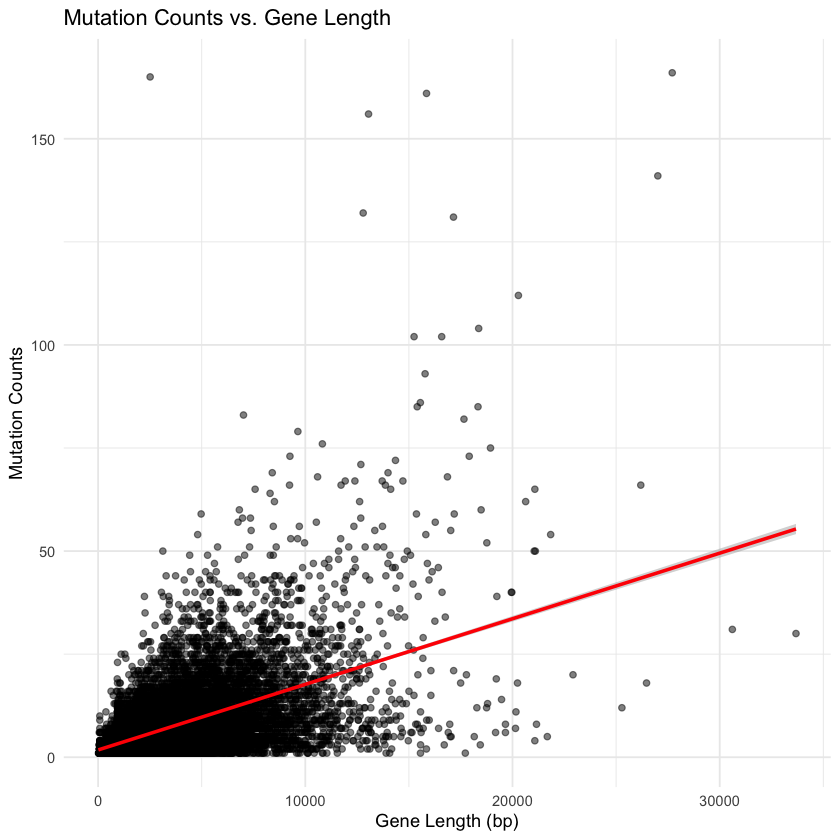

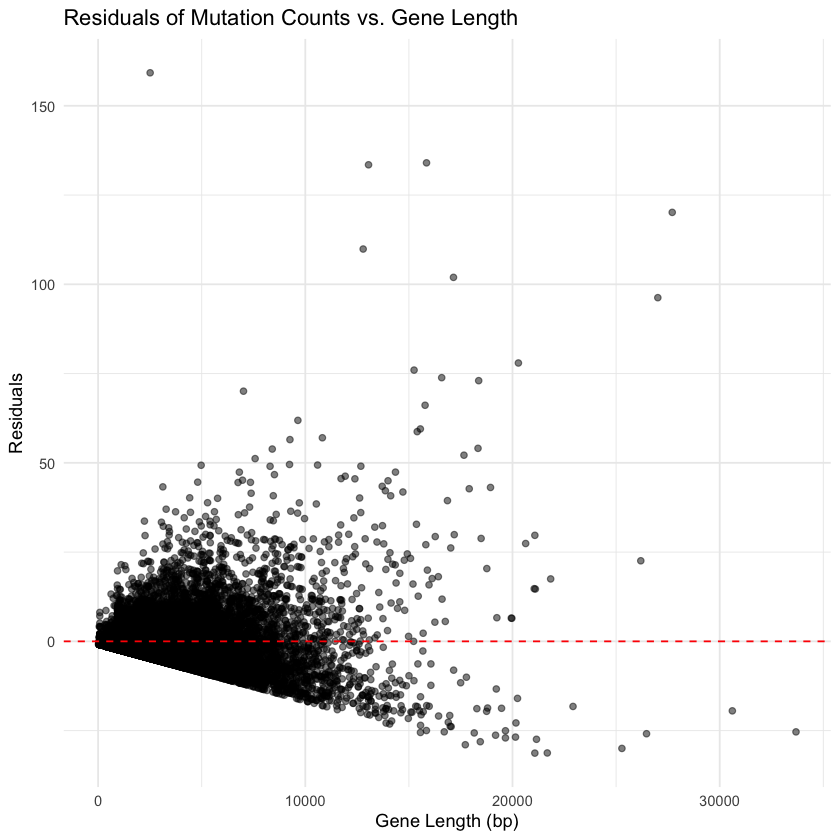

In [26]:
# Scatter Plot
ggplot(mutation_counts_filtered, aes(x = gene_length, y = observed_mutations)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", color = "red") +
  labs(x = "Gene Length (bp)", y = "Mutation Counts", 
       title = "Mutation Counts vs. Gene Length") +
  theme_minimal()

# Correlation Test
cor_test <- cor.test(mutation_counts_filtered$gene_length, mutation_counts_filtered$observed_mutations, method = "pearson")
print(cor_test)

# Linear Model and Residual Plot
lm_fit <- lm(observed_mutations ~ gene_length, data = mutation_counts_filtered)
mutation_counts_filtered$residuals <- residuals(lm_fit)

ggplot(mutation_counts_filtered, aes(x = gene_length, y = residuals)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Gene Length (bp)", y = "Residuals", 
       title = "Residuals of Mutation Counts vs. Gene Length") +
  theme_minimal()

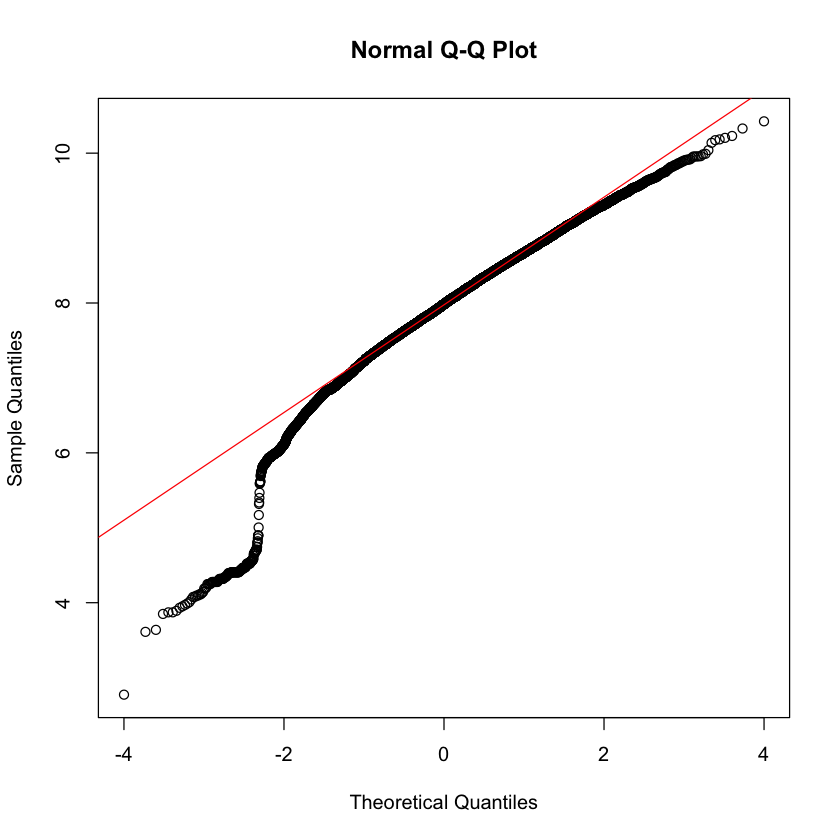

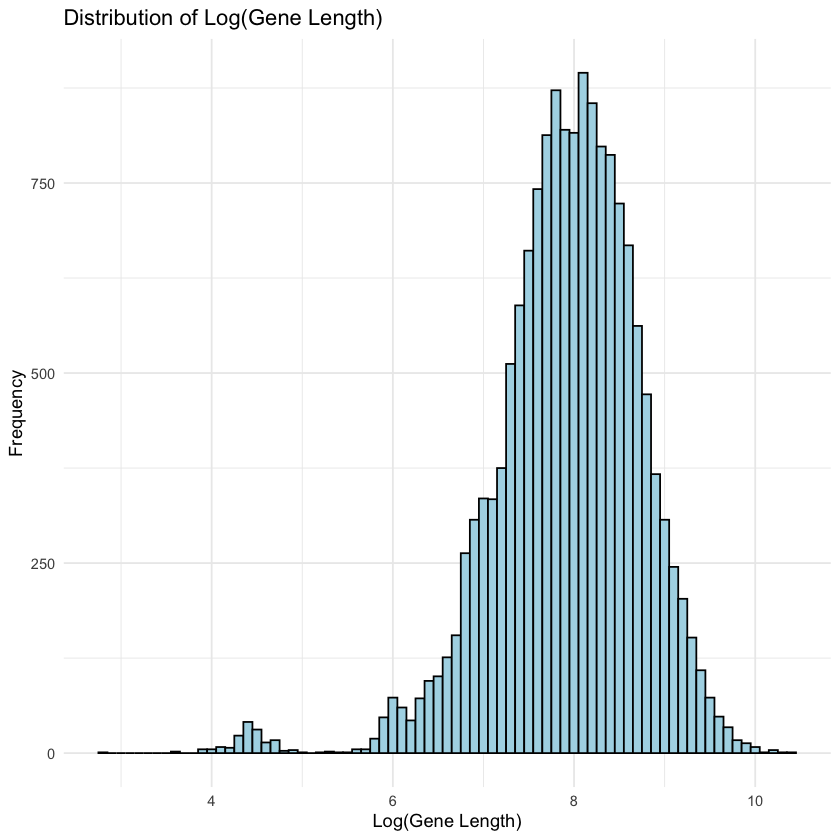

In [28]:
# QQ Plot for log(gene_length)
qqnorm(log(mutation_counts_filtered$gene_length))
qqline(log(mutation_counts_filtered$gene_length), col = "red")

# Histogram of log(gene_length)
ggplot(mutation_counts_filtered, aes(x = log(gene_length))) +
  geom_histogram(binwidth = 0.1, fill = "lightblue", color = "black") +
  labs(x = "Log(Gene Length)", y = "Frequency", 
       title = "Distribution of Log(Gene Length)") +
  theme_minimal()

# # Shapiro-Wilk Test
# shapiro_test <- shapiro.test(log(mutation_counts_filtered$gene_length))
# print(shapiro_test)

# Annotate average SIFT score and dNdS per gene

In [157]:
table(STAD_mutation_filtered_pass$Variant_Classification)


               3'Flank                  3'UTR                5'Flank 
                   415                   5078                    459 
                 5'UTR                 Intron      Missense_Mutation 
                  2540                   3088                  82152 
     Nonsense_Mutation       Nonstop_Mutation                    RNA 
                  4231                     95                   1501 
                Silent            Splice_Site Translation_Start_Site 
                 34115                   1724                    101 

In [156]:
impact_scores <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(avg_sift = mean(SIFT_numeric, na.rm = TRUE)) %>%
  ungroup()

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(impact_scores, by = "Hugo_Symbol")

mutation_counts_filtered$avg_sift <- replace(mutation_counts_filtered$avg_sift, is.na(mutation_counts_filtered$avg_sift), 0)


In [158]:
mutation_types <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(
    dN = sum(Variant_Classification %in% c("Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins", "Splice_Site", "Translation_Start_Site")),
    dS = sum(Variant_Classification %in% c("Silent", "5'UTR", "Intron", "3'UTR", "3'Flank", "5'Flank"))
  ) %>%
  ungroup() %>%
  mutate(dN_dS = (dN / (dS + 1e-6)))

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(mutation_types[, c("Hugo_Symbol", "dN_dS")], by = "Hugo_Symbol")

In [159]:
mutation_types <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(
    dN = sum(Variant_Classification %in% c("Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins", "Splice_Site", "Translation_Start_Site")),
    dS = sum(Variant_Classification %in% c("Silent", "5'UTR", "Intron", "3'UTR", "3'Flank", "5'Flank"))
  ) %>%
  ungroup()

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(mutation_types, by = "Hugo_Symbol")

## Apply poisson distribution to calculate expected mutations and run poisson test

In [160]:
total_mutations <- nrow(STAD_mutation_filtered_pass)
total_gene_length <- sum(mutation_counts_filtered$gene_length, na.rm = TRUE)
mutation_counts_filtered$pos_expected_mutations <- (mutation_counts_filtered$gene_length / total_gene_length) * total_mutations

mutation_counts_filtered$p_value <- mapply(function(obs, exp) {
  poisson.test(obs, r = exp, alternative = "two.sided")$p.value
}, mutation_counts_filtered$observed_mutations, mutation_counts_filtered$pos_expected_mutations)

mutation_counts_filtered$pos_adj_p_value <- p.adjust(mutation_counts_filtered$p_value, method = "BH")
mutation_counts_filtered$pos_selection <- ifelse(mutation_counts_filtered$pos_adj_p_value < 0.05 & mutation_counts_filtered$observed_mutations > mutation_counts_filtered$pos_expected_mutations, "Positive",
                                    ifelse(mutation_counts_filtered$pos_adj_p_value < 0.05 & mutation_counts_filtered$observed_mutations < mutation_counts_filtered$pos_expected_mutations, "Negative", "Neutral"))

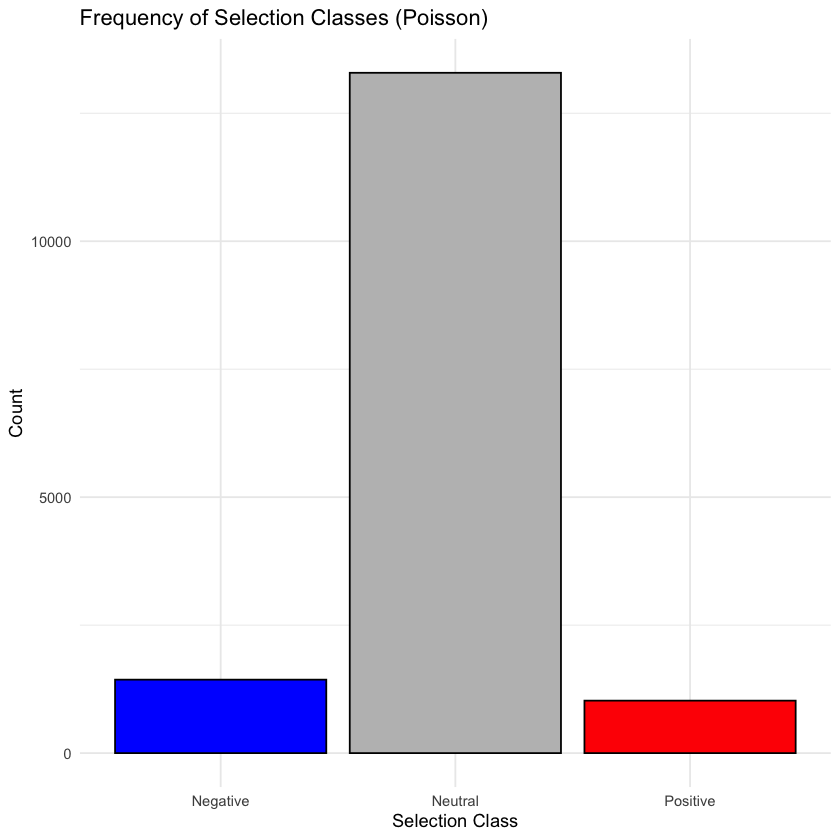

In [161]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$pos_selection))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (Poisson)") +
  theme_minimal() +
  theme(legend.position = "none")

# Some hypotheses

In [162]:
null_model <- glm(observed_mutations ~ 1 + (log_gene_length), 
                  family = poisson(), 
                  data = mutation_counts_filtered)

alt1_model <- glm(observed_mutations ~ avg_sift + (log_gene_length), 
                  family = poisson(), 
                  data = mutation_counts_filtered)

alt2_model <- glm(observed_mutations ~ dN_dS + (log_gene_length), 
                  family = poisson(), 
                  data = mutation_counts_filtered)

combined_model <- glm(observed_mutations ~ avg_sift + dN_dS + (log_gene_length), 
                      family = poisson(), 
                      data = mutation_counts_filtered)

models <- list("SIFT" = alt1_model, 
               "Mutation Type" = alt2_model, 
               "Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.30f, P-value: %.30f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}

dispersion_stat <- summary(combined_model)$deviance / summary(combined_model)$df.residual
cat("\nDispersion statistic for Combined Poisson Model:", dispersion_stat, "\n")
if (dispersion_stat > 1.5) {
  cat("Overdispersion.\n")
}


Likelihood Ratio Test: SIFT vs. Null
LR Statistic: 3.872963518719188868999481201172, P-value: 0.049069805773349413346995362417

Likelihood Ratio Test: Mutation Type vs. Null
LR Statistic: 1693.883594237777288071811199188232, P-value: 0.000000000000000000000000000000

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 1705.399242913583293557167053222656, P-value: 0.000000000000000000000000000000

Dispersion statistic for Combined Poisson Model: 3.906077 
Overdispersion.


## Apply negative binomial 

In [163]:
nb_model <- glm.nb(observed_mutations ~ log(gene_length), data = mutation_counts_filtered)
mutation_counts_filtered$nb_expected <- predict(nb_model, type = "response")
mutation_counts_filtered$nb_p_value <- pchisq(2 * (logLik(glm.nb(observed_mutations ~ 1, data = mutation_counts_filtered)) - 
                                                  logLik(glm.nb(observed_mutations ~ offset(log(gene_length)), data = mutation_counts_filtered))), 
                                              df = 1, lower.tail = FALSE)

mutation_counts_filtered$nb_adj_p_value <- p.adjust(mutation_counts_filtered$nb_p_value, method = "BH")
mutation_counts_filtered$nb_selection <- ifelse(mutation_counts_filtered$nb_adj_p_value < 0.05 & 
                                                mutation_counts_filtered$observed_mutations > mutation_counts_filtered$nb_expected, "Positive",
                                                ifelse(mutation_counts_filtered$nb_adj_p_value < 0.05 & 
                                                       mutation_counts_filtered$observed_mutations < mutation_counts_filtered$nb_expected, "Negative", "Neutral"))

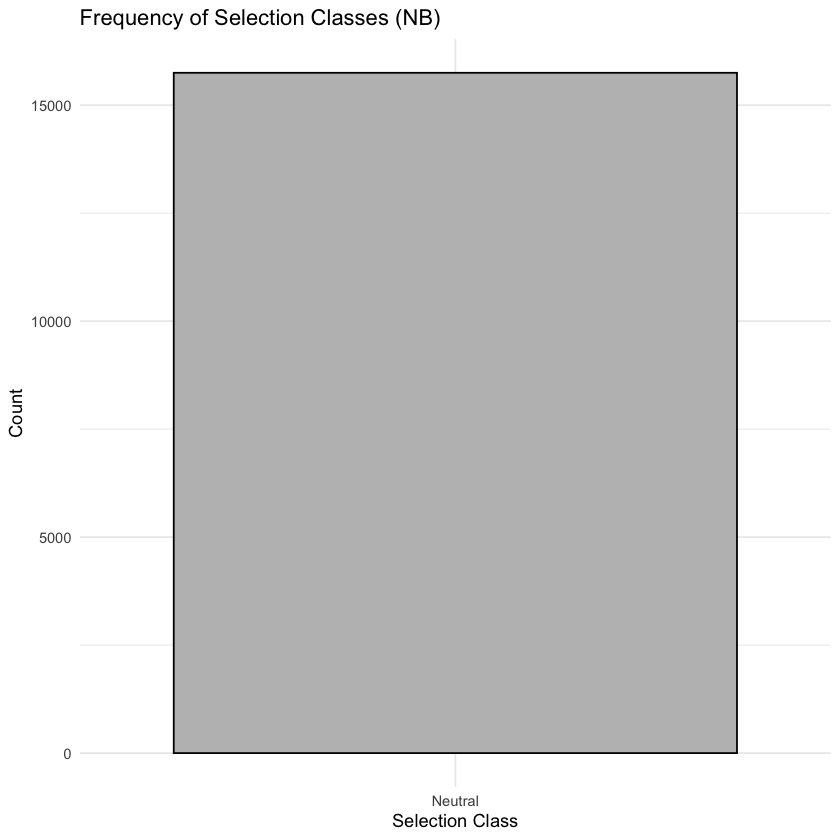

In [164]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$nb_selection))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (NB)") +
  theme_minimal() +
  theme(legend.position = "none")

# Try different hypothesis on NB

In [165]:
# Null Model
null_model <- glm.nb(observed_mutations ~ 1 + (log_gene_length), 
                     data = mutation_counts_filtered)

# Alternative Models
alt1_model <- glm.nb(observed_mutations ~ avg_sift + (log_gene_length), 
                     data = mutation_counts_filtered)

alt2_model <- glm.nb(observed_mutations ~ dN_dS + (log_gene_length), 
                     data = mutation_counts_filtered)


combined_model <- glm.nb(observed_mutations ~ avg_sift + dN_dS + (log_gene_length), 
                         data = mutation_counts_filtered)

# Likelihood Ratio Tests
models <- list("SIFT" = alt1_model, 
               "Mutation Type" = alt2_model,  
               "Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.30f, P-value: %.30f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}


dispersion_stat <- summary(combined_model)$deviance / summary(combined_model)$df.residual
cat("\nDispersion statistic for Combined Negative Model:", dispersion_stat, "\n")
if (dispersion_stat > 1.5) {
  cat("Overdispersion.\n")
}


Likelihood Ratio Test: SIFT vs. Null
LR Statistic: 22.915350603929255157709121704102, P-value: 0.000001692944542539645461071531

Likelihood Ratio Test: Mutation Type vs. Null
LR Statistic: 279.015965356098604388535022735596, P-value: 0.000000000000000000000000000000

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 304.998954173730453476309776306152, P-value: 0.000000000000000000000000000000

Dispersion statistic for Combined Negative Model: 0.9903722 


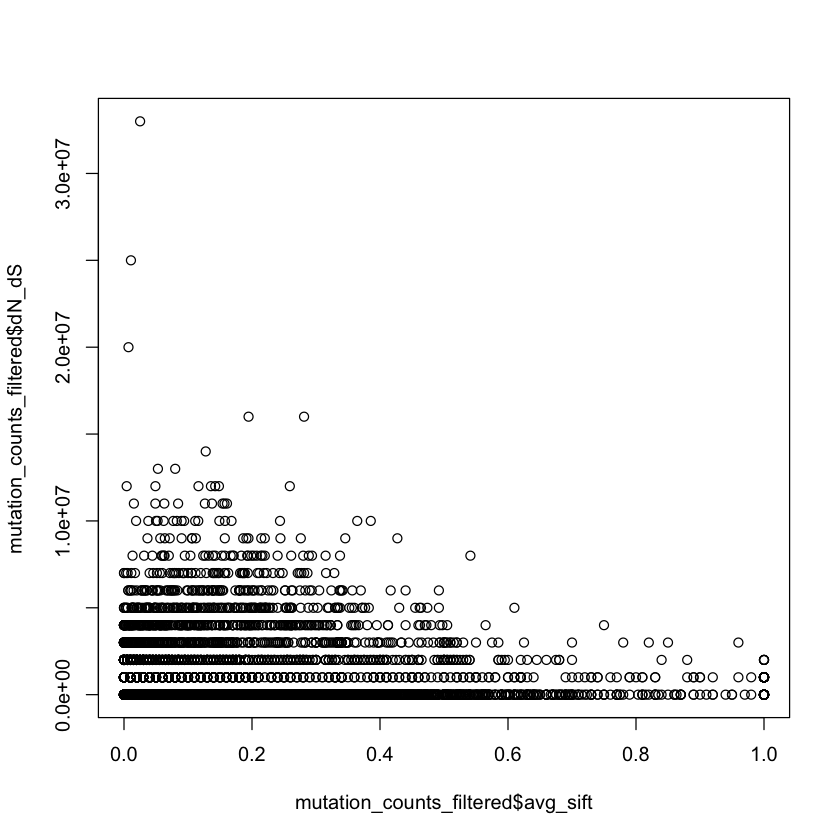

In [166]:
plot(mutation_counts_filtered$avg_sift, y = mutation_counts_filtered$dN_dS)


Genes under Positive Selection:
# A tibble: 16 × 6
   Hugo_Symbol observed_mutations expected_mutations_combined diff_obs_exp
   <chr>                    <int>                       <dbl>        <dbl>
 1 TP53                       165                       6.25        159.  
 2 KRAS                        33                       1.24         31.8 
 3 PGM5                        25                       1.60         23.4 
 4 RHOA                        20                       1.41         18.6 
 5 CSMD3                      156                      18.3         138.  
 6 LRP1B                      161                      20.1         141.  
 7 FLG                        132                      17.5         114.  
 8 PCDH15                      83                      12.2          70.8 
 9 SNORD115-40                 10                       0.699         9.30
10 FAT4                       131                      21.1         110.  
11 TNXB                        50               

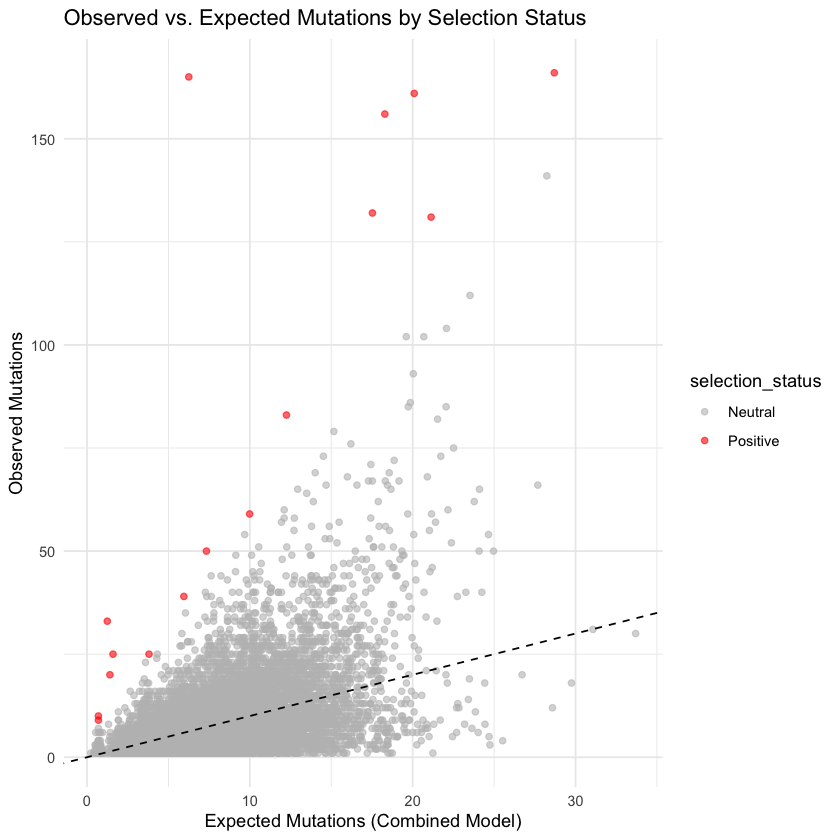

In [167]:
mutation_counts_filtered$expected_mutations_combined <- predict(combined_model, type = "response")

mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    diff_obs_exp = observed_mutations - expected_mutations_combined,
    ratio_obs_exp = observed_mutations / expected_mutations_combined
  )

# Use a Negative Binomial test: compare observed to expected under the NB distribution
mutation_counts_filtered$p_value <- sapply(1:nrow(mutation_counts_filtered), function(i) {
  obs <- mutation_counts_filtered$observed_mutations[i]
  exp <- mutation_counts_filtered$expected_mutations_combined[i]
  theta <- combined_model$theta
  
  # Two-sided test: P(observed >= obs) if obs > exp, P(observed <= obs) if obs < exp
  if (obs > exp) {
    p <- 1 - pnbinom(obs - 1, mu = exp, size = theta)
  } else {
    p <- pnbinom(obs, mu = exp, size = theta)
  }
  return(p)
})

mutation_counts_filtered$adj_p_value <- p.adjust(mutation_counts_filtered$p_value, method = "BH")
mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    selection_status = case_when(
      adj_p_value < 0.05 & ratio_obs_exp > 1 ~ "Positive",
      adj_p_value < 0.05 & ratio_obs_exp < 1 ~ "Negative",
      TRUE ~ "Neutral"
    )
  )

positive_selection <- mutation_counts_filtered %>%
  filter(selection_status == "Positive") %>%
  arrange(adj_p_value) %>%
  dplyr::select(Hugo_Symbol, observed_mutations, expected_mutations_combined, diff_obs_exp, ratio_obs_exp, adj_p_value)

negative_selection <- mutation_counts_filtered %>%
  filter(selection_status == "Negative") %>%
  arrange(adj_p_value) %>%
  dplyr::select(Hugo_Symbol, observed_mutations, expected_mutations_combined, diff_obs_exp, ratio_obs_exp, adj_p_value)

cat("\nGenes under Positive Selection:\n")
print(positive_selection)
cat("\nGenes under Negative Selection:\n")
print(negative_selection)

ggplot(mutation_counts_filtered, aes(x = expected_mutations_combined, y = observed_mutations, color = selection_status)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "gray")) +
  labs(x = "Expected Mutations (Combined Model)", y = "Observed Mutations",
       title = "Observed vs. Expected Mutations by Selection Status") +
  theme_minimal()

## Apply binomial on dN/dS

In [170]:
expected_dN_dS <- median(mutation_counts_filtered$dN_dS)
mutation_counts_filtered$total_mutations <- mutation_counts_filtered$dN + mutation_counts_filtered$dS
mutation_counts_filtered$expected_dN <- mutation_counts_filtered$total_mutations * (expected_dN_dS / (1 + expected_dN_dS))

mutation_counts_filtered$dnds_p_value <- mapply(function(dN, total, exp_dN) {
  if (total == 0) return(1)
  binom.test(dN, total, p = exp_dN/total, alternative = "two.sided")$p.value
}, mutation_counts_filtered$dN, mutation_counts_filtered$total_mutations, mutation_counts_filtered$expected_dN)

mutation_counts_filtered$dnds_adj_p_value <- p.adjust(mutation_counts_filtered$dnds_p_value, method = "BH")
mutation_counts_filtered$dnds_selection <- ifelse(mutation_counts_filtered$dnds_adj_p_value < 0.05 & 
                                                  mutation_counts_filtered$dN > mutation_counts_filtered$expected_dN, "Positive",
                                                  ifelse(mutation_counts_filtered$dnds_adj_p_value < 0.05 & 
                                                         mutation_counts_filtered$dN < mutation_counts_filtered$expected_dN, "Negative", "Neutral"))

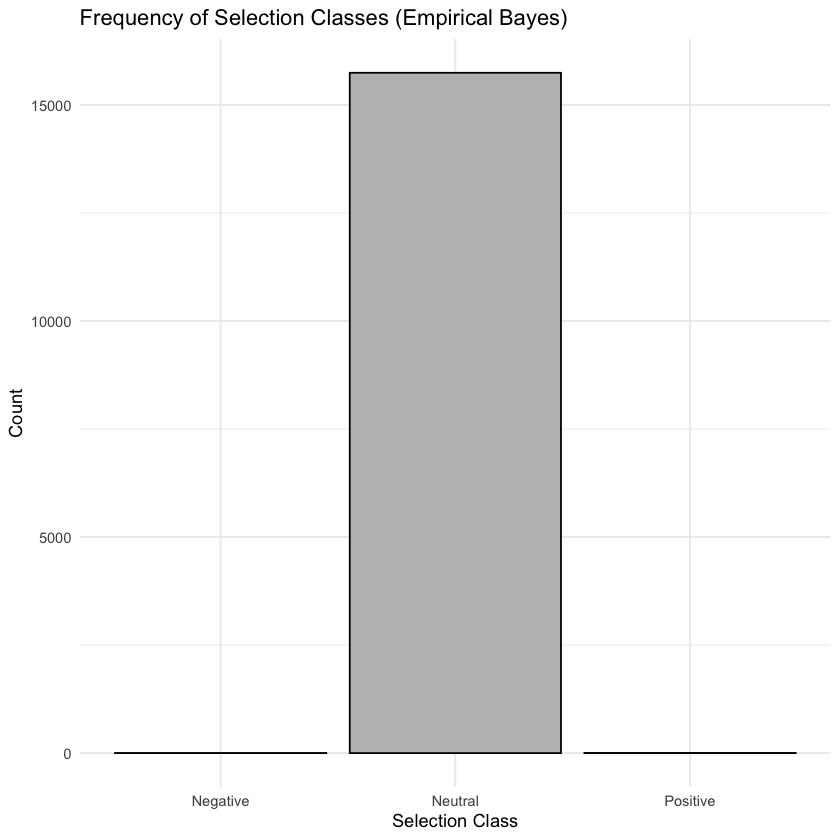

In [171]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$dnds_selection))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (Empirical Bayes)") +
  theme_minimal() +
  theme(legend.position = "none")

# Plotting

In [132]:
# mutation_counts_filtered$logFC <- log2(mutation_counts_filtered$observed_mutations / mutation_counts_filtered$expected_mutations)
# mutation_counts_filtered$neg_log_p <- -log10(mutation_counts_filtered$adj_p_value)

# ggplot(mutation_counts_filtered, aes(x = logFC, y = neg_log_p, color = selection)) +
#   geom_point(alpha = 0.6) +
#   scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
#   labs(x = "Log2 Fold Change (Observed/Expected)", y = "-log10(Adjusted P-value)",
#        title = "Volcano Plot of Mutation Selection") +
#   theme_minimal() +
#   geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black") +
#   geom_vline(xintercept = 0, linetype = "dashed", color = "black")

In [133]:
# library(pheatmap)

# selection_matrix <- as.matrix(mutation_counts_filtered[, c("selection", "nb_selection", "dnds_selection")])
# selection_matrix[selection_matrix == "Positive"] <- 1
# selection_matrix[selection_matrix == "Negative"] <- -1
# selection_matrix[selection_matrix == "Neutral"] <- 0
# selection_matrix <- apply(selection_matrix, 2, as.numeric)

# pheatmap(selection_matrix, 
#          cluster_rows = TRUE, cluster_cols = FALSE,
#          color = c("blue", "grey", "red"),
#          breaks = c(-1.5, -0.5, 0.5, 1.5),
#          labels_row = mutation_counts_filtered$Hugo_Symbol,
#          main = "Selection Across Methods")

In [134]:
# significant_genes <- mutation_counts_filtered %>%
#   filter(adj_p_value < 0.05) %>%
#   slice_head(n = 20)

# plot_data <- data.frame(
#   Gene = rep(significant_genes$Hugo_Symbol, 2),
#   Counts = c(significant_genes$observed_mutations, significant_genes$expected_mutations),
#   Type = rep(c("Observed", "Expected"), each = nrow(significant_genes))
# )

# ggplot(plot_data, aes(x = Gene, y = Counts, fill = Type)) +
#   geom_bar(stat = "identity", position = "dodge") +
#   scale_fill_manual(values = c("Observed" = "dodgerblue", "Expected" = "orange")) +
#   labs(x = "Gene", y = "Mutation Counts", title = "Observed vs. Expected Mutations in Significant Genes") +
#   theme_minimal() +
#   theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [135]:
# mutation_counts_filtered$index <- 1:nrow(mutation_counts_filtered)
# ggplot(mutation_counts_filtered, aes(x = index, y = neg_log_p, color = selection)) +
#   geom_point() +
#   scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
#   labs(x = "Gene Index", y = "-log10(Adjusted P-value)", title = "Manhattan Plot of Mutation Selection") +
#   theme_minimal() +
#   geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black")

# Empirical Bayes

In [95]:
# library(MASS)

# nb_fit <- glm.nb(observed_mutations ~ offset(log(gene_length)), data = mutation_counts_filtered)
# theta <- nb_fit$theta
# mu <- fitted(nb_fit)

# mutation_counts_filtered$eb_selection <- (mutation_counts_filtered$observed_mutations + theta) / (mu + theta)
# mutation_counts_filtered$eb_selection_var <- (mutation_counts_filtered$observed_mutations + theta) / (mu + theta)^2
# mutation_counts_filtered$eb_selection_lower <- mutation_counts_filtered$eb_selection - 1.96 * sqrt(mutation_counts_filtered$eb_selection_var)
# mutation_counts_filtered$eb_selection_upper <- mutation_counts_filtered$eb_selection + 1.96 * sqrt(mutation_counts_filtered$eb_selection_var)
# mutation_counts_filtered$eb_selection_class <- ifelse(mutation_counts_filtered$eb_selection_lower > 1, "Positive",
#                                                       ifelse(mutation_counts_filtered$eb_selection_upper < 1, "Negative", "Neutral"))

In [96]:
# class_counts_df <- as.data.frame(table(mutation_counts_filtered$eb_selection_class))
# colnames(class_counts_df) <- c("Selection_Class", "Count")

# ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
#   geom_bar(stat = "identity", color = "black") +
#   scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
#   labs(x = "Selection Class", y = "Count", 
#        title = "Frequency of Selection Classes (Empirical Bayes)") +
#   theme_minimal() +
#   theme(legend.position = "none")

# Benchmark against filtered STAD_mutation

In [172]:
table(STAD_mutation_filtered_pass$Variant_Type)


   SNP 
135499 

In [173]:
STAD_mutation_sub <- STAD_mutation_filtered_pass[, c("patient_id", "Chromosome", "Start_Position", "Reference_Allele", "Tumor_Seq_Allele2")]
colnames(STAD_mutation_sub) <- c("sampleID", "chr", "pos", "ref", "mut")

In [174]:
STAD_dndsout <- dndscv(STAD_mutation_sub)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(STAD_mutation_sub):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”
Warning message in dndscv(STAD_mutation_sub):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”
    Note: 108 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

    8% ...

    16% ...

    24% ...

    33% ...

    41% ...

    49% ...

    57% ...

    65% ...

    73% ...

    81% ...

    90% ...

    98% ...

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 5.16).



In [176]:
print(STAD_dndsout$nbreg$theta)

[1] 5.15944


In [177]:
STAD_sel_cv = STAD_dndsout$sel_cv
STAD_signif_genes = STAD_sel_cv[STAD_sel_cv$qallsubs_cv<0.05, c("gene_name","qallsubs_cv")]

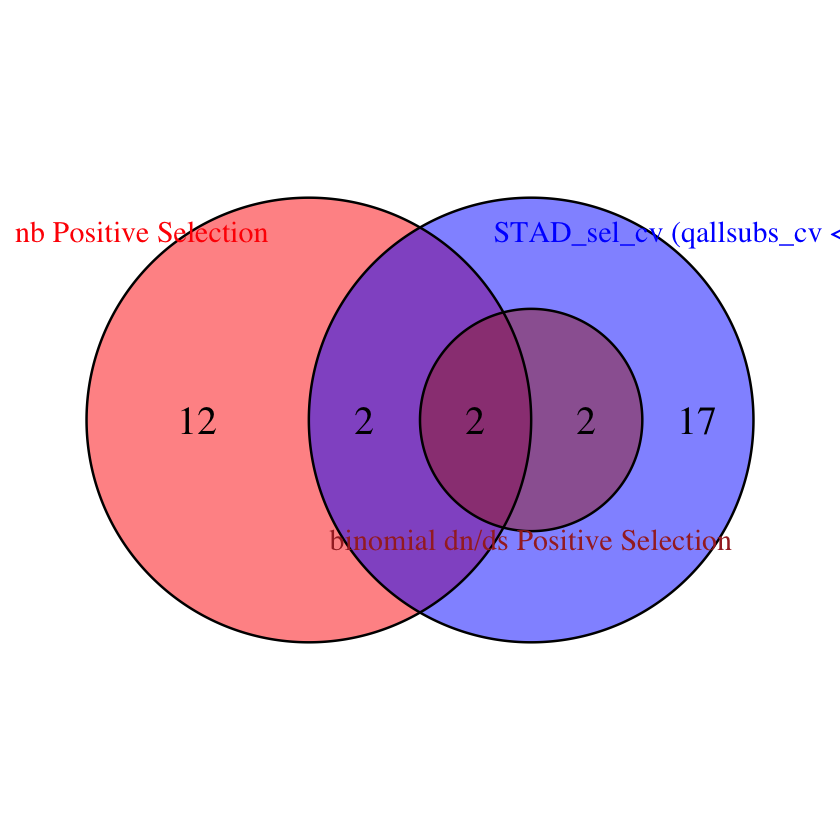

In [178]:
nb_sig_genes <- mutation_counts_filtered %>%
  filter(selection_status == "Positive" & adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

bi_dnds_positive_genes <- mutation_counts_filtered %>%
  filter(dnds_selection == "Positive" & dnds_adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

dndscv_significant_genes <- STAD_sel_cv %>%
  filter(qallsubs_cv < 0.05) %>%
  pull(gene_name) %>%
  unique()

fill_colors <- c("red", "blue", 'brown')

venn_plot <- venn.diagram(
  x = list(
    "nb Positive Selection" = nb_sig_genes,
    "STAD_sel_cv (qallsubs_cv < 0.1)" = dndscv_significant_genes,
    "binomial dn/ds Positive Selection" = bi_dnds_positive_genes
  ),
  filename = NULL, 
  fill = fill_colors,
  alpha = 0.5,
  label.col = "black",
  cex = 2, 
  cat.cex = 1.5,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

In [179]:
intersect(nb_sig_genes, dndscv_significant_genes)

[1] "KRAS" "PGM5" "RHOA" "TP53"

In [180]:
intersect(bi_dnds_positive_genes, dndscv_significant_genes)

[1] "ARID1A" "KRAS"   "PIK3CA" "TP53"

In [181]:
signif_genes_localmodel = as.vector(STAD_dndsout$sel_loc$gene_name[STAD_dndsout$sel_loc$qall_loc<0.1])
print(signif_genes_localmodel)

[1] "TP53"   "ARID1A" "PIK3CA" "KRAS"   "APC"    "ARID2"  "PPP3CA" "BCOR"  


# Take a look at full STAD_mutation

In [182]:
full_STAD_mutation <- STAD_mutation[, c("patient_id", "Chromosome", "Start_Position", "Reference_Allele", "Tumor_Seq_Allele2")]
colnames(full_STAD_mutation) <- c("sampleID", "chr", "pos", "ref", "mut")

In [183]:
full_STAD_dndsout <- dndscv(full_STAD_mutation)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(full_STAD_mutation):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”
Warning message in dndscv(full_STAD_mutation):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”
    Note: 6 samples excluded for exceeding the limit of mutations per sample (see the max_coding_muts_per_sample argument in dndscv). 409 samples left after filtering.

    Note: 372 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

    7% ...

    15% ...

    22% ...

    30% ...

    37% ...

    44% ...

    52% ...

    59% ...

    66% ...

    74% ...

    81% ...

    89% ...

    96% ...

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Re

In [184]:
print(full_STAD_dndsout$nbreg$theta)

[1] 5.506695


In [185]:
full_signif_genes_localmodel = as.vector(full_STAD_dndsout$sel_loc$gene_name[full_STAD_dndsout$sel_loc$qall_loc<0.1])
print(full_signif_genes_localmodel)

[1] "TP53"   "ARID1A" "PIK3CA" "KRAS"   "APC"    "MLH1"   "ARID2"  "PPP3CA"
[9] "ERBB3" 


In [188]:
library(car)

In [189]:
vif(combined_model)

avg_sift           dN_dS log_gene_length 
       1.001569        1.004664        1.003643

# 20250429_oncodriveFML_corrected

In [204]:
FML = read_delim("20250429cbase/q_values_20250429cbase.txt", delim="\t", skip = 1)

Rows: 18439 Columns: 30
── Column specification ───────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): gene
dbl (29): p_phi_m_neg, q_phi_m_neg, phi_m_neg, p_phi_k_neg, q_phi_k_neg, phi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


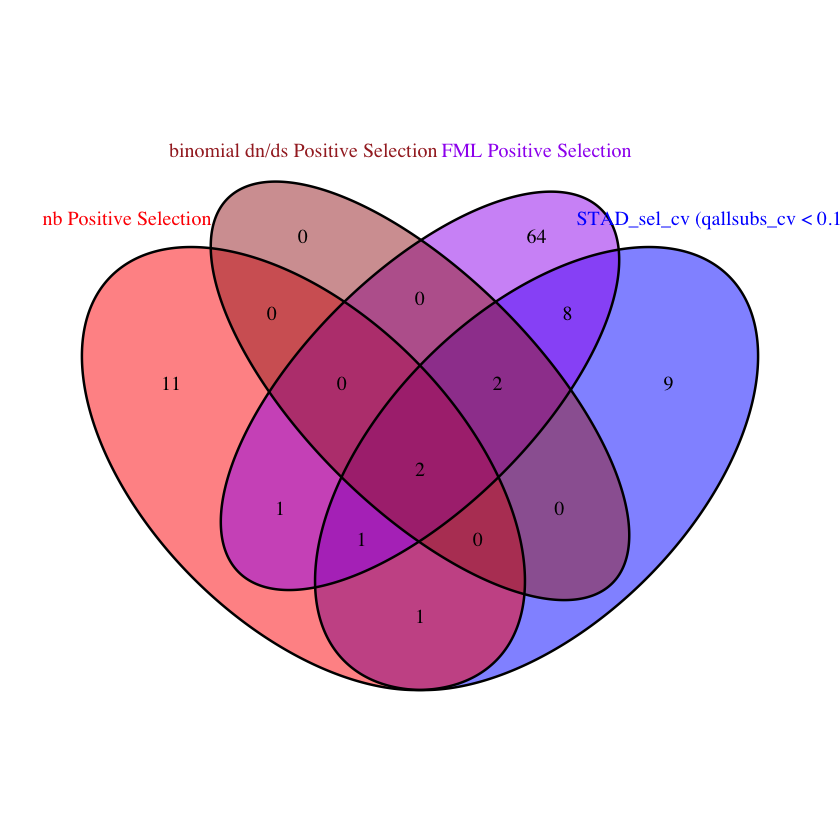

In [209]:
nb_sig_genes <- mutation_counts_filtered %>%
  filter(selection_status == "Positive" & adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

bi_dnds_positive_genes <- mutation_counts_filtered %>%
  filter(dnds_selection == "Positive" & dnds_adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

dndscv_significant_genes <- STAD_sel_cv %>%
  filter(qallsubs_cv < 0.05) %>%
  pull(gene_name) %>%
  unique()

FML_sig_genes <- FML %>%
  filter(q_phi_pos < 0.05) %>%
  pull(gene) %>%
  unique()

fill_colors <- c("red", "blue", 'brown', 'purple')

venn_plot <- venn.diagram(
  x = list(
    "nb Positive Selection" = nb_sig_genes,
    "STAD_sel_cv (qallsubs_cv < 0.1)" = dndscv_significant_genes,
    "binomial dn/ds Positive Selection" = bi_dnds_positive_genes,
    "FML Positive Selection" = FML_sig_genes
  ),
  filename = NULL, 
  fill = fill_colors,
  # alpha = 0.5,
  label.col = "black",
  # cex = 2, 
  # cat.cex = 1.5,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

#  20250429_oncodriveCLUSTL_STAD_corrected